In [1]:
# task1##
import numpy as np
import scipy
import matplotlib
import qiskit
import torch



### TASK_2

###Born Rule 
for a state dscribed by a density matrix ρ and measurement operator M_k,the probability of observing outcome k is given by :
p(k)=Tr(M_k ρ)
**measurements
M_k=P_k
P_k^2=P_k
sigma(kP_k)=I
**POVMs
M_k=E_k
E_k>=0
sigma(kE_k)=I

###Pauli Projective Measurements
pauli projective measurements correspond to measuring in the eigenbases of sigmax,y,z
Each basic comsists of two rank-1 projectors that sum to identity,ensuring a valid projective measurement
these measurements are hardware-native and are the basis of classical shadow tomogaphy

In [2]:
Pz0=np.array([[1,0],[0,0]])
Pz1=np.array([[0,0],[0,1]])
Px_plus=0.5*np.array([[1,1],[1,1]])
Px_minus=0.5*np.array([[1,-1],[-1,1]])
Py_plus=0.5*np.array([[1,-1j],[1j,1]])
Py_minus=0.5*np.array([[1,1j],[-1j,1]])


In [3]:
from typing import Dict, Any
import pathlib
import json

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    
    I=np.eye(2)
    operators={
        "Z":{
            "0":Pz0,
            "1":Pz1
        },
        "X":{
            "plus":Px_plus,
            "minus":Px_minus
        },
        "Y":{
            "plus":Py_plus,
            "minus":Py_minus
        }
    }
    completeness={}
    for basis,oper in operators.items():
        completeness[basis]=np.allclose(sum(oper.values()),I)
    return {
        "type":"pauli",
        "operators":operators,
        "completeness":completeness,
        "metadata":{
            "qubits":1,
            "info_complete": True,
             "used_in":"classical_shadows"
        }
    }    
    
    
measurement_model=build_measurement_model(pathlib.Path("."))
measurement_model["completeness"]

{'Z': True, 'X': True, 'Y': True}

References for single-qubit states<br>
1.|0>-- circuit:|0> <br>
2.|1>-- circuit X|0><br>
3. |+>=(|0>+|1>)/1.414.. H|0><br>
4.|->=(|0>-|1>)/1.414.. X->H|0><br>
5.(|0>+i|1>)/1.414.. H->S|0>

In [4]:
reference_states = {
    "|0>": ["Id"],
    "|1>": ["X"],
    "|+>": ["H"],
    "|->": ["X", "H"],
    "(|0>+i|1>)/√2": ["H", "S"]
}

reference_states


{'|0>': ['Id'],
 '|1>': ['X'],
 '|+>': ['H'],
 '|->': ['X', 'H'],
 '(|0>+i|1>)/√2': ['H', 'S']}

In [5]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

In [6]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [7]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

Density Matrix <br>
histogram picture encodes:<br>
Bar height :|rhoij|--> magnitude of density matrix elements<br>
color: arg(rhoij)--> reprresing comple phase<br>
diagonal elements indicate population probs,while non diagonal elements capture coherence.bell state visualitioons clearly show strong non diagonal corelations,confirming entangelement structure.

# TASK_3

##  QST Data Generation<br>
For each preparede reference state,measurements shots are excuted under the chosen pauli projectetive measurement modek useing a quantum simulator.<br>
raw measurement counts and computed probability are recoreded and serilized.Density matrices are stored for later validation and benchmarking

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix

def build_reference_circuit(state_name: str)->QuantumCircuit:
    qc=QuantumCircuit(1)
    if state_name=="zero":
        pass
    elif state_name=="one":
        qc.x(0)
    elif state_name=="plus":
        qc.h(0)
    elif state_name=="minus":
        qc.x(0)
        qc.h(0)
    elif state_name=="phase":
        qc.h(0)
        qc.s(0)
    else :
        raise ValueError(f"unsupported state {state_name}")   
    return qc
def density_matrix_from_circuit(qc):
    return DensityMatrix.from_instruction(qc).data             
        

In [9]:
from qiskit_aer import Aer
from qiskit import transpile
import numpy as np

backend=Aer.get_backend("qasm_simulator")
def run_measurements(qc,basis:str,shots:int,seed: int=42):
    meas_circuit=qc.copy()
    if basis=="X":
        meas_circuit.h(0)
    elif basis=="Y":
        meas_circuit.sdg(0)
        meas_circuit.h(0)
    elif basis=="Z":
        pass
    else :
        raise ValueError("unknown basis")
    meas_circuit.measure_all()
    tqc=transpile(meas_circuit,backend)
    job=backend.run(tqc,shots=shots)
    result=job.result()
    counts=result.get_counts()
    probs={k:v/shots for k,v in counts.items()}
    return counts,probs
        

In [10]:
from dataclasses import dataclass
from typing import List
import pathlib
@dataclass
class DatasetVariant:
    name:str
    circuit_summary:str
    measurement_model:str
    measurement_data_path:pathlib.Path
    metadata_path:pathlib.Path
    density_matrix_path:pathlib.Path
    

In [11]:
import json
from textwrap import indent
def generate_measurement_dataset(variants:List[DatasetVariant],shots:int =1024)-> None:
    for variant in variants:
        qc=build_reference_circuit(variant.name)
        rho=density_matrix_from_circuit(qc)
        measurement_data={}
        for basis in ["X","Y","Z"]:
            counts,probs=run_measurements(qc,basis,shots)
            measurement_data[basis]={
                "counts":counts,
                "probabilites":probs
            }
            np.save(variant.measurement_data_path,measurement_data)
            np.save(variant.density_matrix_path,rho)
            metadata={
                "state":variant.name,
                "circuit_summary":variant.circuit_summary,
                "measurement_model":variant.measurement_model,
                "shots":shots,
                "bases":["X","Y","Z"]
            }
            with open(variant.metadata_path,"w") as f:
                json.dump(metadata,f,indent=2)
            print(f"saved dataset for {variant.name}")    

In [12]:
variants = [
    DatasetVariant(
        name="zero",
        circuit_summary="|0>",
        measurement_model="pauli_projective",
        measurement_data_path=pathlib.Path("single_qubit_0.npy"),
        metadata_path=pathlib.Path("single_qubit_0_metadata.json"),
        density_matrix_path=pathlib.Path("single_qubit_0_rho.npy")
    ),
    DatasetVariant(
        name="plus",
        circuit_summary="H|0>",
        measurement_model="pauli_projective",
        measurement_data_path=pathlib.Path("single_qubit_plus.npy"),
        metadata_path=pathlib.Path("single_qubit_plus_metadata.json"),
        density_matrix_path=pathlib.Path("single_qubit_plus_rho.npy")
    ),
    DatasetVariant(
        name="phase",
        circuit_summary="H → S |0>",
        measurement_model="pauli_projective",
        measurement_data_path=pathlib.Path("single_qubit_phase.npy"),
        metadata_path=pathlib.Path("single_qubit_phase_metadata.json"),
        density_matrix_path=pathlib.Path("single_qubit_phase_rho.npy")
    )
]

generate_measurement_dataset(variants)


saved dataset for zero
saved dataset for zero
saved dataset for zero
saved dataset for plus
saved dataset for plus
saved dataset for plus
saved dataset for phase
saved dataset for phase
saved dataset for phase


# Task 4

In [13]:
DATA_DIR=pathlib.Path("data/single_qubit")
DATA_DIR.mkdir(parents=True,exist_ok=True)


In [14]:
def pauli_expectation(probs):
    return probs.get("0",0)-probs.get("1",0)
def reconstruct_density_matrix(expectations):
    rx,ry,rz=expectations["X"],expectations["Y"] ,expectations["Z"]
    I=np.eye(2)
    X=np.array([[0,1],[1,0]])
    Y=np.array([[0,-1j],[1j,0]])
    Z=np.array([[1,0],[0,-1]])
    rho=0.5*(I+rx*X+ry*Y+rz*Z)
    return rho  

In [15]:
def trace_distance(rho,sigma):
    diff=rho-sigma
    eigs=np.linalg.eigvals(diff)
    return 0.5*np.sum(np.abs(eigs))

def bloch_vector(rho):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    return np.array([
        np.real(np.trace(rho @ X)),
        np.real(np.trace(rho @ Y)),
        np.real(np.trace(rho @ Z))
    ])    

In [16]:
def make_pysical_density_matrix(rho):
    rho=0.5*(rho+rho.conj().T)
    eigvals,eigvecs=np.linalg.eigh(rho)
    eigvals=np.clip(eigvals,0,None)
    rho_physical=eigvecs@np.diag(eigvals)@eigvecs.conj().T
    rho_physical=rho_physical/np.trace(rho_physical)
    return rho_physical

In [17]:
from qiskit.quantum_info import state_fidelity
def single_qubit_tomography(state_name,shots=2048):
    qc=build_reference_circuit(state_name)
    rho_true=DensityMatrix.from_instruction(qc).data
    expectations={}
    measurement_data={}
    for basis in ["X","Y","Z"]:
        counts,probs=run_measurements(qc,basis,shots)
        expectations[basis]=pauli_expectation(probs)
        measurement_data[basis]={
            "counts":counts,
            "probabilites":probs
        }
    rho_est=make_pysical_density_matrix(reconstruct_density_matrix(expectations))
    metrics={
        "fidelity":state_fidelity(rho_true,rho_est),
        "trace_distance":trace_distance(rho_true,rho_est),
        "bloch_error":float(np.linalg.norm(bloch_vector(rho_true)-bloch_vector(rho_est)))
    }    
    return rho_true,rho_est,measurement_data,metrics

In [18]:
states=["zero","one","plus","minus","phase"]
results={}
for i in states:
    rho_true,rho_est,measurement_data,metrics=single_qubit_tomography(i)
    np.save(DATA_DIR/f"{i}_measurements.npy",measurement_data)
    np.save(DATA_DIR/f"{i}_rho_true.npy",rho_true)
    np.save(DATA_DIR/f"{i}_rho_reconstructed.npy",rho_est)
    with open(DATA_DIR/f"{i}_metrics.json","w") as f:
        json.dump(metrics,f,indent=2)
    results[i]=metrics   
    print(i,metrics) 


zero {'fidelity': 0.9996843944549605, 'trace_distance': 0.01776529045749021, 'bloch_error': 0.03553058091498041}
one {'fidelity': 0.9999806892138691, 'trace_distance': 0.0043944039561961, 'bloch_error': 0.008788807912392201}
plus {'fidelity': 0.9995081539063574, 'trace_distance': 0.02217760342423092, 'bloch_error': 0.04435520684846184}
minus {'fidelity': 0.9999301579927676, 'trace_distance': 0.008357153057883794, 'bloch_error': 0.016714306115767585}
phase {'fidelity': 0.9997688943065993, 'trace_distance': 0.015202160813526289, 'bloch_error': 0.03040432162705258}


summary<br>
linear inversion tomography doesnt gurantee a physical density matrix.small negative eigenvalues were removed througn eigenvalue clipping and trace renormalization to enforce complete positivity.this procedure is standeard in practical qst

# Task_5

In [19]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
def summarize_validation_runs(result_path: Sequence[Path])->None:
    records=[]
    for Path in result_path:
        with open(Path,"r") as f:
            metrics=json.load(f)
        state_name=Path.stem.replace("_metrics","")
        metrics["state"]=state_name 
        records.append(metrics)
    df=pd.DataFrame(records).set_index("state")
    display(df)
    fig,ax=plt.subplots(1,3,figsize=(15,4))
    df["fidelity"].plot(kind="bar",ax=ax[0],title="fidelity")
    df["trace_distance"].plot(kind="bar",ax=ax[1],title="trace distance")
    df["bloch_error"].plot(kind="bar",ax=ax[2],title="bloch vector error")
    for a in ax:
        a.grid(True)
    plt.tight_layout()
    plt.show()    



,fidelity,trace_distance,bloch_error
state,,,
minus,0.999930,0.008357,0.016714
one,0.999981,0.004394,0.008789
phase,0.999769,0.015202,0.030404
plus,0.999508,0.022178,0.044355
zero,0.999684,0.017765,0.035531


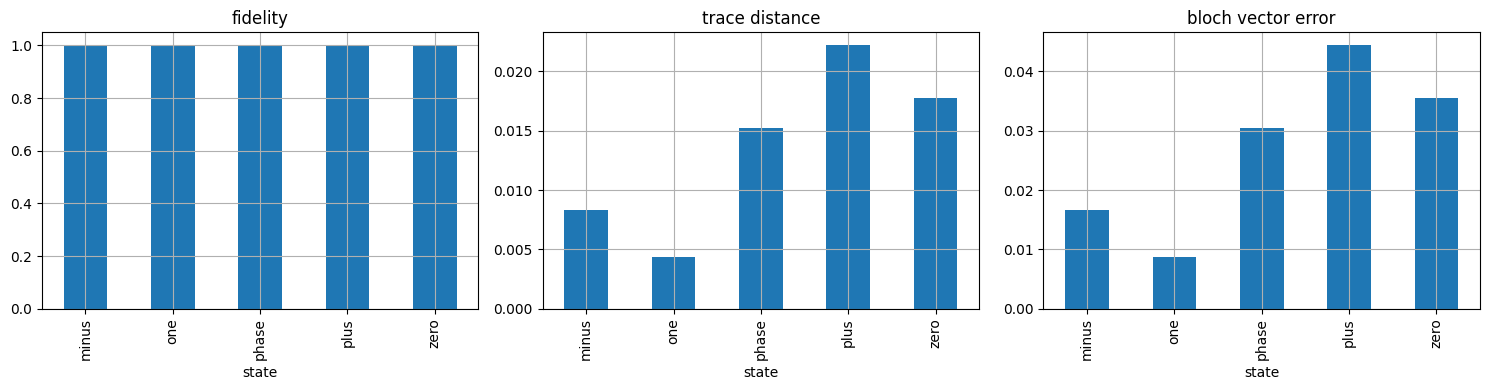

In [20]:
metric_files = list(DATA_DIR.glob("*_metrics.json"))
summarize_validation_runs(metric_files)


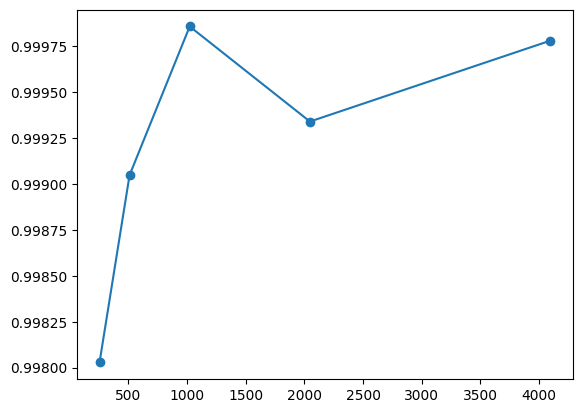

In [21]:
shot_counts=[256,512,1024,2048,4096]
fidelities=[]
for shots in shot_counts:
    rho_true,rho_est,_,metrics=single_qubit_tomography("plus",shots=shots)
    fidelities.append(metrics["fidelity"])
plt.figure()
plt.plot(shot_counts,fidelities,marker="o")
    

In [22]:
plot_density_matrix_histogram(
    np.load(DATA_DIR / "plus_rho_true.npy"),
    basis_labels=["0","1"],
    title="True Density Matrix |+⟩"
)

plot_density_matrix_histogram(
    np.load(DATA_DIR / "plus_rho_reconstructed.npy"),
    basis_labels=["0","1"],
    title="Reconstructed Density Matrix |+⟩"
)


### Sources of Reconstruction Error

1. **Shot Noise**   
2. **Linear Inversion Artifacts**   
3. **Measurement Model Limitations**   
4. **Simulator Assumptions**

### Mitigation Strategies

Increasing the number of measurement shots<br>
Enforcing physicality via eigenvalue clipping<br>
Using maximum-likelihood estimation (MLE)<br>
Exploring SIC POVMs for improved sample efficiency<br>
Incorporating noise-aware reconstruction models


In [23]:
import pandas as pd

df_summary = pd.DataFrame({
    "State": results.keys(),
    "Fidelity": [results[s]["fidelity"] for s in results],
    "Trace Distance": [results[s]["trace_distance"] for s in results],
    "Bloch Error": [results[s]["bloch_error"] for s in results],
})

df_summary


,State,Fidelity,Trace Distance,Bloch Error
0,zero,0.999684,0.017765,0.035531
1,one,0.999981,0.004394,0.008789
2,plus,0.999508,0.022178,0.044355
3,minus,0.999930,0.008357,0.016714
4,phase,0.999769,0.015202,0.030404
